# The Bench Mark Model (Mobile Net V2)

This is the model which will act as a benchmark for all other models. The model is designed to be what other models aspire to achieve interms of accuracy on my dataset.

In [1]:
import tensorflow as tf
import numpy as np
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob
import shutil
import tensorflow_hub as hub
import datetime

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,auc,precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay,ConfusionMatrixDisplay

In [3]:
_URL = 'https://fire-net-datasets.s3.amazonaws.com/Training_Dataset.zip'

zip_file = tf.keras.utils.get_file(origin=_URL,extract=True)  
#This will get the file and extract it to a directory and extract to /Training Dataset

2006548480/2006536205 [==============================] - 26s 0us/step


In [4]:
print(os.path.dirname(zip_file))
#This function returns the directory of the extracted folder without the extracted folder inclusive

/root/.keras/datasets


In [5]:
LOG_DIR = os.path.join(os.getcwd(), "Fire_Detection/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#Create a directory for the tensorboard logs

In [6]:
base_dir = os.path.join(os.path.dirname(zip_file), 'Training Dataset')
#A good way to add the directory of the extracted folder and also the extracted folder itself.
print(base_dir)

/root/.keras/datasets/Training Dataset


In [7]:
classes = ['Fire', 'NoFire']

In [8]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.7)], images[round(len(images)*0.7):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Fire: 3622 Images
NoFire: 4125 Images


In [9]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [10]:
batch_size = 100
IMG_SHAPE = 128

In [11]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                    zoom_range = 0.5,
                    rotation_range=45,
                    horizontal_flip=True,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.2)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                            directory=train_dir,
                                            shuffle=True,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            class_mode='binary')
print(train_data_gen.samples)
print(train_data_gen.n)
#Find our size of datasets. each

Found 5423 images belonging to 2 classes.
5423
5423


In [12]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

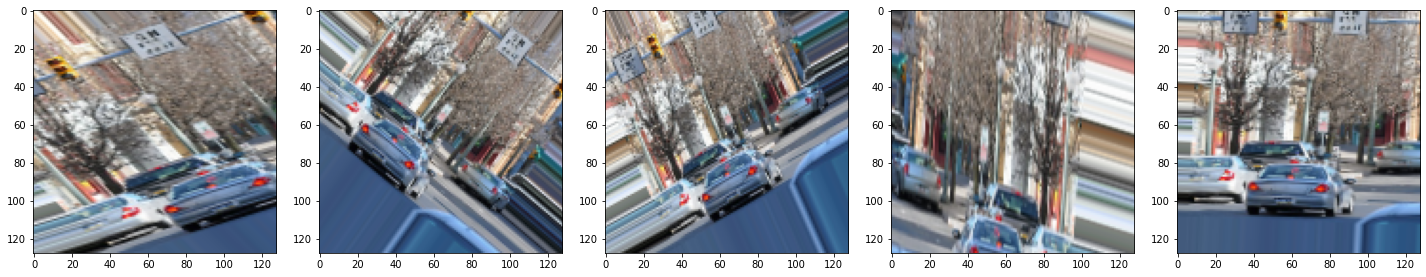

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [14]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                            directory=val_dir,
                            shuffle = False,
                            target_size=(IMG_SHAPE,IMG_SHAPE),
                            class_mode='binary')
#put shuffle=False when you do test_datagen.flow_from_directory() so the samples don't get shuffled and have the same order as validation_generator.classes

Found 2324 images belonging to 2 classes.


In [15]:
URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/5'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE,IMG_SHAPE,3))

In [16]:
feature_extractor.trainable=False

In [17]:
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2,activation=tf.nn.softmax)
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
EPOCHS = 25
model.compile(optimizer="adam",
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

#Use them if need be
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='auto')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')

#Can use one reduce Learning Rate or Early Stopping.

#Since we have a reduce learning rate, curve will become smooth, no need to restore best weights since best
#weights may be the ones got at the early stop when the val_loss hasn't changed by 1e-4 when curve has smoothened.

tensorboard_callback = tf.keras.callbacks.TensorBoard(LOG_DIR, histogram_freq=1)

history = model.fit(train_data_gen,epochs= EPOCHS,
                validation_data = val_data_gen,callbacks=[tensorboard_callback])

Epoch 1/25
55/55 [==============================] - 105s 2s/step - loss: 0.3058 - accuracy: 0.8634 - val_loss: 0.1610 - val_accuracy: 0.9458
Epoch 2/25
55/55 [==============================] - 92s 2s/step - loss: 0.1915 - accuracy: 0.9257 - val_loss: 0.1433 - val_accuracy: 0.9466
Epoch 3/25
55/55 [==============================] - 92s 2s/step - loss: 0.1701 - accuracy: 0.9342 - val_loss: 0.1325 - val_accuracy: 0.9509
Epoch 4/25
55/55 [==============================] - 92s 2s/step - loss: 0.1502 - accuracy: 0.9410 - val_loss: 0.1154 - val_accuracy: 0.9570
Epoch 5/25
55/55 [==============================] - 92s 2s/step - loss: 0.1500 - accuracy: 0.9404 - val_loss: 0.1183 - val_accuracy: 0.9557
Epoch 6/25
55/55 [==============================] - 92s 2s/step - loss: 0.1443 - accuracy: 0.9441 - val_loss: 0.1136 - val_accuracy: 0.9561
Epoch 7/25
55/55 [==============================] - 92s 2s/step - loss: 0.1382 - accuracy: 0.9423 - val_loss: 0.1145 - val_accuracy: 0.9548
Epoch 8/25
55/55 [=

In [ ]:
#Run this on AWS 
EFS_PATH_LOG_DIR = "/".join(LOG_DIR.strip("/").split('/')[1:-1])
print (EFS_PATH_LOG_DIR)


"""
Run this command in the terminal

pip install tensorboard
tensorboard --logdir <EFS_PATH_LOG_DIR>

To launch TensorBoard, copy your Studio URL and replace lab? with proxy/6006/ as follows. You must include the trailing / character.

https://<YOUR_URL>.studio.region.sagemaker.aws/jupyter/default/proxy/6006/

"""

In [26]:
import tensorboard

In [28]:
#Run this on Colab or other places

#Can run this before training to view the logs before training occurs or run after training to view after training
!tensorboard --logdir logs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 320, in _exit_function
    def _exit_function(info=info, debug=debug, _run_finalizers=_run_finalizers,
KeyboardInterrupt


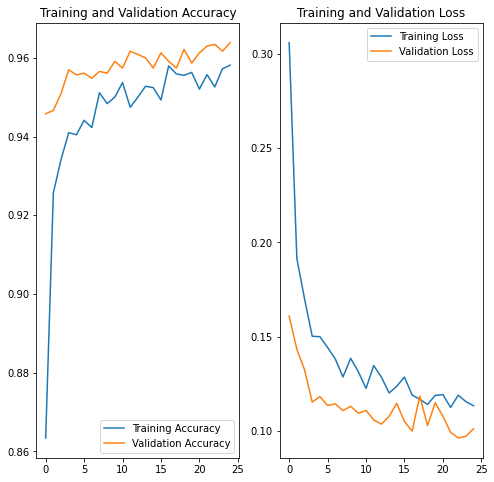

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range,acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:
#Confusion Matrix and Classification Report

#Something is Wrong
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1024   63]
 [  21 1216]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.98      0.94      0.96      1087
     No Fire       0.95      0.98      0.97      1237

    accuracy                           0.96      2324
   macro avg       0.97      0.96      0.96      2324
weighted avg       0.96      0.96      0.96      2324



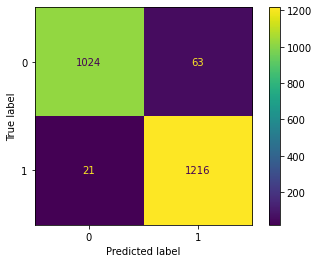

In [23]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

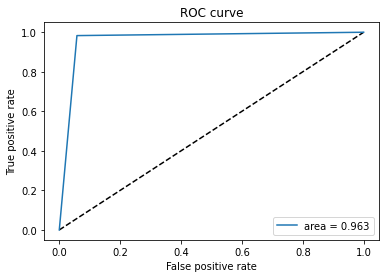

In [24]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_data_gen.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

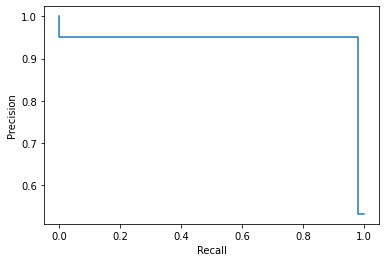

In [25]:
prec, recall, _ = precision_recall_curve(val_data_gen.classes, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()